### Methods – Model comparison paragraph

**Methods → Phenotyping → Model comparison**:

> We developed two candidate phenotyping systems: a physiology-only MMSP solution applied within comorbidity strata, and a multi-view SNF-lite solution that fused chronic (C-view), socio-contextual (S-view) and physiologic (P-view) information. For each stratum we evaluated internal validity in each method’s native representation (PCA scores of the P-view for MMSP, spectral embedding of the fused similarity graph for SNF-lite), computing bootstrap stability (adjusted Rand index), silhouette, Calinski–Harabasz and Davies–Bouldin indices. The pre-specified decision rule favoured solutions with higher stability, higher silhouette and Calinski–Harabasz indices and lower Davies–Bouldin index. MMSP is retained as a physiology-focused comparator, whereas SNF-lite serves as the primary multi-view phenotyping system in downstream analyses.

### Results – Short comparison + decision

**Results → Phenotype selection**:

> In the high-multimorbidity stratum, the MMSP solution with (K=5) clusters achieved a stability ARI of 0.22, silhouette 0.12 and Calinski–Harabasz index 91. In contrast, the SNF-lite solution with (K=3) clusters achieved a higher stability ARI (0.48), higher silhouette (0.27) and markedly higher Calinski–Harabasz index (407), with a lower Davies–Bouldin index, indicating more compact and well-separated clusters in its fused multi-view space. Similar patterns were seen in the low- and mid-multimorbidity strata. On this basis, we selected the SNF-lite phenotypes as the primary clustering solution for MAIP, and retained the MMSP phenotypes as a physiology-based sensitivity analysis.

one-liner for the portfolio page:<br>

> **Choice of phenotyping system.** We compared a physiology-only MMSP solution to a multi-view SNF-lite solution using stability and internal validity indices in each method’s native representation. SNF-lite consistently showed higher stability and better separation, so we use it as the primary multi-view phenotyping system and present MMSP as a complementary, physiology-focused comparator.

---




In [1]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().resolve()
if not (ROOT / "data").exists() and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent
REPORTS = ROOT / "reports"

model_sel = pd.read_csv(REPORTS / "model_comparisons.csv")
display(model_sel)


,Stratum,Method,K,Stability (ARI),Silhouette,Calinski–Harabasz,Davies–Bouldin
0,High MM,MMSP,5,0.221,0.115,91.16,2.48
1,High MM,SNF-lite,3,0.477,0.273,406.91,1.25
2,Mid MM,MMSP,3,0.321,0.110,367.23,2.80
3,Mid MM,SNF-lite,3,0.670,0.319,1566.30,1.13
4,Low MM,MMSP,4,0.267,0.114,370.92,2.61
5,Low MM,SNF-lite,3,0.607,0.388,1961.89,1.05


In [ ]:
# # General dataset descriptions/EDA basics.

# data = pd.read_csv(ROOT / "data" / "01_processed" / "support_preprocessed_clean.csv")
# descr_df = data.describe().T
# descr_df.to_csv(REPORTS / "data_descriptions.csv")

### External prognostic utility

This cell will:

* Build a **common base Cox model** per stratum:
  `age (splines if possible) + sex + num.co + severity (aps/sps/scoma)`
* Fit:

  * **Base** (no clusters)
  * **Base+M** (MMSP clusters)
  * **Base+S** (SNF-lite clusters)
* Compare:

  * C-index
  * ΔC vs base
  * AIC & log-likelihood
  * Likelihood-ratio test p-values for MMSP/SNF vs base
* Save the results into a nice table under `reports/tables`.

---




In [18]:
# ROOT = Path(".")  # project root

snf_high = pd.read_csv(ROOT / "reports" / "snf_high" / "tables" / "snf_assignments.csv")
snf_mid  = pd.read_csv(ROOT / "reports" / "snf_mid"  / "tables" / "snf_assignments.csv")
snf_low  = pd.read_csv(ROOT / "reports" / "snf_low"  / "tables" / "snf_assignments.csv")

snf_high["stratum"] = "High_MM"
snf_mid["stratum"]  = "Mid_MM"
snf_low["stratum"]  = "Low_MM"

snf_all = pd.concat([snf_high, snf_mid, snf_low], ignore_index=True)

snf_all = snf_all.rename(columns={"cluster": "cluster_id"})
snf_all["label"] = snf_all["stratum"] + "_" + snf_all["cluster_id"].astype(int).astype(str)

out = ROOT / "data" / "02_clusters" / "snf_clusters_all.csv"
out.parent.mkdir(parents=True, exist_ok=True)
snf_all.to_csv(out, index=False)
print("Wrote:", out)

Wrote: /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/snf_clusters_all.csv


In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score

ROOT = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP")

# if not (ROOT / "data").exists():
#     # maybe we're in notebooks/ or src/ -> try one level up
#     if (ROOT.parent / "data").exists():
#         ROOT = ROOT.parent
#     # or two levels up (just in case)
#     elif (ROOT.parent.parent / "data").exists():
#         ROOT = ROOT.parent.parent
#     else:
#         raise FileNotFoundError(
#             f"Could not find a 'data' directory from {ROOT}. "
#             "Please set ROOT manually, e.g. ROOT = Path('/Users/.../ProjectMAIP')."
#         )
# # ROOT = Path(__file__).resolve().parents[1]  # or Path("..").resolve()

PROC = ROOT / "data" / "01_processed"
CLUS = ROOT / "data" / "02_clusters"

C = pd.read_csv(PROC / "C_view.csv")
P = pd.read_csv(PROC / "P_view_scaled.csv")
S = pd.read_csv(PROC / "S_view.csv")
Y = pd.read_csv(PROC / "Y_validation.csv")
L_mmsp = pd.read_csv(CLUS / "mmsp_clusters.csv")
L_snf  = pd.read_csv(CLUS / "snf_clusters_all.csv")

# merge into df
df = (
    C.merge(P, on="eid")
     .merge(S, on="eid")
     .merge(Y, on="eid")
     .merge(L_mmsp[["eid","stratum","label"]].rename(columns={"label":"label_mmsp"}),
            on="eid", how="inner")
)

merge_keys = ["eid"] + (["stratum"] if "stratum" in L_snf.columns else [])
df = df.merge(
    L_snf[merge_keys + ["cluster_id","label"]]
        .rename(columns={"cluster_id":"cluster_id_snf","label":"label_snf"}),
    on=merge_keys,
    how="inner",
)

stratum_col = "stratum"
mmsp_col = "label_mmsp"
snf_col  = "label_snf"
duration_col = "d.time"
event_col    = "death"
base_covars_core = ["age"]
covar_priority = ["aps","sps","scoma"]

In [23]:
# ============================================================
# External prognostic utility: Cox PH per stratum (stable version)
# ============================================================

import numpy as np
from scipy import stats
from lifelines.exceptions import ConvergenceError

# --- Guard: make sure df exists ---
if "df" not in globals():
    raise RuntimeError("df is not defined. Run the data-loading/setup cell first.")

# Severity covariate priority if not already defined
if "covar_priority" not in globals():
    covar_priority = ["aps", "sps", "scoma"]

# Required base covariates present in df
required_base = ["age", "sex", "num.co"]
missing_req = [c for c in required_base if c not in df.columns]
if missing_req:
    raise ValueError(f"Missing required base covariates in df: {missing_req}")

prognostic_records = []

for stratum, g in df.groupby(stratum_col):
    print(f"\n=== Prognostic comparison: Stratum {stratum} ===")
    
    # Choose severity covariate available in this stratum
    severity = next((c for c in covar_priority if c in g.columns), None)
    if severity is None:
        print(f"[WARN] Stratum={stratum}: no severity covariate (aps/sps/scoma) found, skipping.")
        continue
    
    # Common dataset for base, MMSP, SNF models
    cols_all = [duration_col, event_col, "age", "sex", "num.co", severity, mmsp_col, snf_col]
    g_all = g[cols_all].dropna().copy()
    
    n_rows = g_all.shape[0]
    n_events = int(g_all[event_col].sum())
    
    # Need enough data and at least some events + non-events
    if n_rows < 50 or n_events < 10 or g_all[event_col].nunique() < 2:
        print(f"[WARN] Stratum={stratum}: insufficient data (N={n_rows}, events={n_events}), skipping.")
        continue
    
    print(f"Using N={n_rows}, events={n_events}, severity={severity}")
    
    # --- Base design matrix: linear age, sex, num.co, severity ---
    base_cols = [duration_col, event_col, "age", "sex", "num.co", severity]
    base_X = g_all[base_cols].copy()
    
    # Fit base Cox model with small ridge penalizer for stability
    cph_base = CoxPHFitter(penalizer=0.01)
    try:
        cph_base.fit(base_X, duration_col=duration_col, event_col=event_col)
    except ConvergenceError as e:
        print(f"[WARN] Base model failed to converge for stratum {stratum}: {e}")
        continue
    
    c_base = cph_base.concordance_index_
    aic_base = cph_base.AIC_partial_
    ll_base = cph_base.log_likelihood_
    
    print(f"  Base model C-index = {c_base:.3f}")
    
    def fit_with_clusters(cluster_col, prefix):
        """
        Fit base + cluster model and compute LR vs base.

        Returns:
            c_idx, aic, ll, lr_stat, df_lr, lr_p
        """
        # one-hot encode clusters (drop first to avoid collinearity)
        dummies = pd.get_dummies(
            g_all[cluster_col].astype(str),
            prefix=prefix,
            drop_first=True,
        ).reset_index(drop=True)
        
        X_full = pd.concat([base_X.reset_index(drop=True), dummies], axis=1)
        
        cph = CoxPHFitter(penalizer=0.01)
        try:
            cph.fit(X_full, duration_col=duration_col, event_col=event_col)
        except ConvergenceError as e:
            print(f"[WARN] Cox fit failed for {prefix} in stratum {stratum}: {e}")
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        except Exception as e:
            print(f"[WARN] Cox fit error for {prefix} in stratum {stratum}: {e}")
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        
        c_idx = cph.concordance_index_
        aic = cph.AIC_partial_
        ll = cph.log_likelihood_
        
        # Likelihood ratio test vs base model
        lr_stat = 2.0 * (ll - ll_base)
        df_lr = X_full.shape[1] - base_X.shape[1]  # number of added cluster dummies
        if df_lr > 0:
            lr_p = 1.0 - stats.chi2.cdf(lr_stat, df_lr)
        else:
            lr_p = np.nan
        
        return c_idx, aic, ll, lr_stat, df_lr, lr_p
    
    # Base + MMSP clusters
    c_mmsp, aic_mmsp, ll_mmsp, lr_mmsp, df_mmsp, lr_p_mmsp = fit_with_clusters(mmsp_col, "mmsp")
    if not np.isnan(c_mmsp):
        print(f"  Base+MMSP C-index = {c_mmsp:.3f} (ΔC = {c_mmsp - c_base:+.3f})")
    
    prognostic_records.append(
        {
            "Stratum": stratum,
            "Method": "MMSP",
            "N": n_rows,
            "Events": n_events,
            "Severity_covar": severity,
            "C_base": c_base,
            "C_method": c_mmsp,
            "Delta_C": c_mmsp - c_base if not np.isnan(c_mmsp) else np.nan,
            "AIC_base": aic_base,
            "AIC_method": aic_mmsp,
            "LL_base": ll_base,
            "LL_method": ll_mmsp,
            "LR_stat": lr_mmsp,
            "LR_df": df_mmsp,
            "LR_p": lr_p_mmsp,
        }
    )
    
    # Base + SNF clusters
    c_snf, aic_snf, ll_snf, lr_snf, df_snf, lr_p_snf = fit_with_clusters(snf_col, "snf")
    if not np.isnan(c_snf):
        print(f"  Base+SNF C-index = {c_snf:.3f} (ΔC = {c_snf - c_base:+.3f})")
    
    prognostic_records.append(
        {
            "Stratum": stratum,
            "Method": "SNF-lite",
            "N": n_rows,
            "Events": n_events,
            "Severity_covar": severity,
            "C_base": c_base,
            "C_method": c_snf,
            "Delta_C": c_snf - c_base if not np.isnan(c_snf) else np.nan,
            "AIC_base": aic_base,
            "AIC_method": aic_snf,
            "LL_base": ll_base,
            "LL_method": ll_snf,
            "LR_stat": lr_snf,
            "LR_df": df_snf,
            "LR_p": lr_p_snf,
        }
    )

# Collect into a DataFrame and save
prognostic_df = pd.DataFrame.from_records(prognostic_records)
display(prognostic_df)

out_path = ROOT / "reports" / "tables" / "table_external_prognostic_comparison.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
prognostic_df.to_csv(out_path, index=False)
print(f"\nSaved prognostic comparison table to {out_path}")



=== Prognostic comparison: Stratum High_MM ===
Using N=1100, events=788, severity=aps
  Base model C-index = 0.661
  Base+MMSP C-index = 0.668 (ΔC = +0.008)
  Base+SNF C-index = 0.677 (ΔC = +0.017)

=== Prognostic comparison: Stratum Low_MM ===
Using N=4183, events=2765, severity=aps
  Base model C-index = 0.641
  Base+MMSP C-index = 0.647 (ΔC = +0.007)
  Base+SNF C-index = 0.683 (ΔC = +0.042)

=== Prognostic comparison: Stratum Mid_MM ===
Using N=3822, events=2648, severity=aps
  Base model C-index = 0.643
  Base+MMSP C-index = 0.651 (ΔC = +0.009)
  Base+SNF C-index = 0.656 (ΔC = +0.013)


,Stratum,Method,N,Events,Severity_covar,C_base,C_method,Delta_C,AIC_base,AIC_method,LL_base,LL_method,LR_stat,LR_df,LR_p
0,High_MM,MMSP,1100,788,aps,0.660539,0.668128,0.007589,9884.137210,9876.963612,-4938.068605,-4930.481806,15.173598,4,4.354381e-03
1,High_MM,SNF-lite,1100,788,aps,0.660539,0.677369,0.016830,9884.137210,9856.713864,-4938.068605,-4922.356932,31.423346,2,1.501437e-07
2,Low_MM,MMSP,4183,2765,aps,0.640911,0.647478,0.006568,42701.864089,42631.771334,-21346.932044,-21308.885667,76.092755,3,2.220446e-16
3,Low_MM,SNF-lite,4183,2765,aps,0.640911,0.683157,0.042246,42701.864089,42270.927238,-21346.932044,-21129.463619,434.936851,2,0.000000e+00
4,Mid_MM,MMSP,3822,2648,aps,0.642510,0.651111,0.008601,40121.661992,40082.485600,-20056.830996,-20035.242800,43.176391,2,4.210811e-10
5,Mid_MM,SNF-lite,3822,2648,aps,0.642510,0.655640,0.013130,40121.661992,40045.547694,-20056.830996,-20016.773847,80.114298,2,0.000000e+00



Saved prognostic comparison table to /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/tables/table_external_prognostic_comparison.csv


In [24]:
# ============================================================
# Cross-validated prognostic utility (fixed C-index orientation)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceError

# --- Guard: make sure df exists ---
if "df" not in globals():
    raise RuntimeError("df is not defined. Run the data-loading/setup cell first.")

# Severity covariate priority if not already defined
if "covar_priority" not in globals():
    covar_priority = ["aps", "sps", "scoma"]

# Required base covariates present in df
required_base = ["age", "sex", "num.co"]
missing_req = [c for c in required_base if c not in df.columns]
if missing_req:
    raise ValueError(f"Missing required base covariates in df: {missing_req}")

cv_records = []
N_SPLITS = 5
RANDOM_STATE = 42

for stratum, g in df.groupby(stratum_col):
    print(f"\n=== CV prognostic comparison: Stratum {stratum} ===")
    
    # Choose severity covariate available in this stratum
    severity = next((c for c in covar_priority if c in g.columns), None)
    if severity is None:
        print(f"[WARN] Stratum={stratum}: no severity covariate (aps/sps/scoma) found, skipping.")
        continue
    
    # Common dataset for base, MMSP, SNF models
    cols_all = [duration_col, event_col, "age", "sex", "num.co", severity, mmsp_col, snf_col]
    g_all = g[cols_all].dropna().copy()
    
    n_rows = g_all.shape[0]
    n_events = int(g_all[event_col].sum())
    
    if n_rows < 50 or n_events < 10 or g_all[event_col].nunique() < 2:
        print(f"[WARN] Stratum={stratum}: insufficient data (N={n_rows}, events={n_events}), skipping.")
        continue
    
    print(f"Using N={n_rows}, events={n_events}, severity={severity}")
    
    base_feature_cols = ["age", "sex", "num.co", severity]
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    
    fold_id = 0
    for train_idx, test_idx in kf.split(g_all):
        fold_id += 1
        train = g_all.iloc[train_idx].copy()
        test  = g_all.iloc[test_idx].copy()
        
        # Ensure test fold has at least one event & one censor
        if test[event_col].nunique() < 2 or test[event_col].sum() < 2:
            print(f"[WARN] Stratum={stratum}, fold={fold_id}: too few events in test fold, skipping.")
            continue
        
        # --------- Base model ---------
        df_train_base = train[[duration_col, event_col] + base_feature_cols].copy()
        df_test_base  = test[[duration_col, event_col] + base_feature_cols].copy()
        
        cph_base = CoxPHFitter(penalizer=0.01)
        try:
            cph_base.fit(df_train_base, duration_col=duration_col, event_col=event_col)
        except ConvergenceError as e:
            print(f"[WARN] Base model failed in stratum {stratum}, fold={fold_id}: {e}")
            continue
        
        # lifelines' own concordance on the test fold
        c_base_cv = cph_base.score(df_test_base, scoring_method="concordance_index")
        cv_records.append(
            {
                "Stratum": stratum,
                "Fold": fold_id,
                "Method": "Base",
                "C_index": c_base_cv,
            }
        )
        
        # Helper to fit base + cluster model and compute CV C-index
        def cv_fit_with_clusters(cluster_col, prefix):
            # One-hot encode cluster labels on train
            dummies_train = pd.get_dummies(
                train[cluster_col].astype(str),
                prefix=prefix,
                drop_first=True,
            )
            dummy_cols = dummies_train.columns.tolist()
            
            # Align test dummies to train columns
            dummies_test = pd.get_dummies(
                test[cluster_col].astype(str),
                prefix=prefix,
                drop_first=True,
            ).reindex(columns=dummy_cols, fill_value=0)
            
            df_train = pd.concat(
                [
                    df_train_base.reset_index(drop=True),
                    dummies_train.reset_index(drop=True),
                ],
                axis=1,
            )
            df_test = pd.concat(
                [
                    df_test_base.reset_index(drop=True),
                    dummies_test.reset_index(drop=True),
                ],
                axis=1,
            )
            
            feature_cols = base_feature_cols + dummy_cols
            cols_for_fit = [duration_col, event_col] + feature_cols
            
            cph = CoxPHFitter(penalizer=0.01)
            try:
                cph.fit(df_train[cols_for_fit],
                        duration_col=duration_col,
                        event_col=event_col)
            except ConvergenceError as e:
                print(f"[WARN] {prefix} model failed in stratum {stratum}, fold={fold_id}: {e}")
                return np.nan
            
            c_idx = cph.score(df_test, scoring_method="concordance_index")
            return c_idx
        
        # --------- MMSP model ---------
        c_mmsp_cv = cv_fit_with_clusters(mmsp_col, "mmsp")
        if not np.isnan(c_mmsp_cv):
            cv_records.append(
                {
                    "Stratum": stratum,
                    "Fold": fold_id,
                    "Method": "MMSP",
                    "C_index": c_mmsp_cv,
                }
            )
        
        # --------- SNF-lite model ---------
        c_snf_cv = cv_fit_with_clusters(snf_col, "snf")
        if not np.isnan(c_snf_cv):
            cv_records.append(
                {
                    "Stratum": stratum,
                    "Fold": fold_id,
                    "Method": "SNF-lite",
                    "C_index": c_snf_cv,
                }
            )

# Turn into DataFrame
cv_df = pd.DataFrame.from_records(cv_records)
display(cv_df.head())

# Attach base C-index per fold to compute Delta_C_cv
base_cv = (
    cv_df[cv_df["Method"] == "Base"][["Stratum", "Fold", "C_index"]]
    .rename(columns={"C_index": "C_base_cv"})
)
cv_df = cv_df.merge(base_cv, on=["Stratum", "Fold"], how="left")
cv_df["Delta_C_cv"] = np.where(
    cv_df["Method"].isin(["MMSP", "SNF-lite"]),
    cv_df["C_index"] - cv_df["C_base_cv"],
    np.nan,
)

# Summary per stratum & method
cv_summary = (
    cv_df.groupby(["Stratum", "Method"])
    .agg(
        C_index_mean=("C_index", "mean"),
        C_index_sd=("C_index", "std"),
        Delta_C_mean=("Delta_C_cv", "mean"),
        Delta_C_sd=("Delta_C_cv", "std"),
        Folds_used=("C_index", "count"),
    )
    .reset_index()
)

display(cv_summary)

out_dir = ROOT / "reports" / "tables"
out_dir.mkdir(parents=True, exist_ok=True)
cv_df.to_csv(out_dir / "table_external_prognostic_cv_folds.csv", index=False)
cv_summary.to_csv(out_dir / "table_external_prognostic_cv_summary.csv", index=False)
print(f"\nSaved CV fold-level results to {out_dir/'table_external_prognostic_cv_folds.csv'}")
print(f"Saved CV summary to {out_dir/'table_external_prognostic_cv_summary.csv'}")



=== CV prognostic comparison: Stratum High_MM ===
Using N=1100, events=788, severity=aps

=== CV prognostic comparison: Stratum Low_MM ===
Using N=4183, events=2765, severity=aps

=== CV prognostic comparison: Stratum Mid_MM ===
Using N=3822, events=2648, severity=aps


,Stratum,Fold,Method,C_index
0,High_MM,1,Base,0.678251
1,High_MM,1,MMSP,0.688997
2,High_MM,1,SNF-lite,0.705141
3,High_MM,2,Base,0.671583
4,High_MM,2,MMSP,0.681338


,Stratum,Method,C_index_mean,C_index_sd,Delta_C_mean,Delta_C_sd,Folds_used
0,High_MM,Base,0.659083,0.016530,NaN,NaN,5
1,High_MM,MMSP,0.661667,0.022772,0.002584,0.015258,5
2,High_MM,SNF-lite,0.673918,0.021989,0.014835,0.011832,5
3,Low_MM,Base,0.639721,0.012720,NaN,NaN,5
4,Low_MM,MMSP,0.645876,0.010383,0.006154,0.005646,5
5,Low_MM,SNF-lite,0.682195,0.011135,0.042473,0.002505,5
6,Mid_MM,Base,0.642473,0.016058,NaN,NaN,5
7,Mid_MM,MMSP,0.649744,0.015352,0.007271,0.002398,5
8,Mid_MM,SNF-lite,0.654774,0.014586,0.012301,0.004367,5



Saved CV fold-level results to /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/tables/table_external_prognostic_cv_folds.csv
Saved CV summary to /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/tables/table_external_prognostic_cv_summary.csv


Prognostic performance was evaluated using 5-fold cross-validated Harrell’s C-index for 6-month mortality within each multimorbidity stratum. The base model included age, sex, number of comorbidities (num.co) and APS, and was compared against versions augmented with MMSP or SNF-lite phenotypes. Across low (N = 4,183; 2,765 deaths), mid (N = 3,822; 2,648 deaths) and high multimorbidity (N = 1,100; 788 deaths), SNF-lite clusters consistently delivered larger gains in cross-validated C-index than MMSP clusters, with the strongest uplift in the low- and high-burden groups.

In [25]:
# ============================================================
# Parsimony & interpretability: cluster counts and balance
# ============================================================

import pandas as pd
import numpy as np

if "df" not in globals():
    raise RuntimeError("df is not defined. Run the data-loading cell first.")

def cluster_summary(df, stratum_col, label_col, method_name):
    """
    For each stratum:
      - K = number of clusters
      - N = total N
      - min / max cluster sizes and proportions
    """
    rows = []
    for s, g in df.groupby(stratum_col):
        sizes = g[label_col].value_counts().sort_index()
        N = sizes.sum()
        K = sizes.shape[0]
        props = sizes / N
        rows.append(
            {
                "Stratum": s,
                "Method": method_name,
                "K": K,
                "N": N,
                "Cluster_sizes": "; ".join(f"{lab}: {n}" for lab, n in sizes.items()),
                "Min_prop": props.min(),
                "Max_prop": props.max(),
            }
        )
    return pd.DataFrame(rows)

mmsp_parsimony = cluster_summary(df, stratum_col, mmsp_col, "MMSP")
snf_parsimony  = cluster_summary(df, stratum_col, snf_col,  "SNF-lite")

parsimony_table = pd.concat([mmsp_parsimony, snf_parsimony], ignore_index=True)
display(parsimony_table)

out_path = ROOT / "reports" / "tables" / "table_parsimony_cluster_balance.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
parsimony_table.to_csv(out_path, index=False)
print("Saved parsimony summary to", out_path)


,Stratum,Method,K,N,Cluster_sizes,Min_prop,Max_prop
0,High_MM,MMSP,5,1100,High_MM_0: 18; High_MM_1: 112; High_MM_2: 513;...,0.016364,0.466364
1,Low_MM,MMSP,4,4183,Low_MM_0: 1833; Low_MM_1: 335; Low_MM_2: 781; ...,0.080086,0.438202
2,Mid_MM,MMSP,3,3822,Mid_MM_0: 1086; Mid_MM_1: 1905; Mid_MM_2: 831,0.217425,0.498430
3,High_MM,SNF-lite,3,1100,High_MM_0: 346; High_MM_1: 413; High_MM_2: 341,0.310000,0.375455
4,Low_MM,SNF-lite,3,4183,Low_MM_0: 1256; Low_MM_1: 477; Low_MM_2: 2450,0.114033,0.585704
5,Mid_MM,SNF-lite,3,3822,Mid_MM_0: 1002; Mid_MM_1: 1689; Mid_MM_2: 1131,0.262166,0.441915


Saved parsimony summary to /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/tables/table_parsimony_cluster_balance.csv


In [27]:

mmsp = pd.read_csv("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/mmsp_clusters.csv")

out_dir = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters")
out_dir.mkdir(parents=True, exist_ok=True)

for s in ["High_MM", "Mid_MM", "Low_MM"]:
    df_s = mmsp[mmsp["stratum"] == s][["eid", "label"]].copy()
    df_s.to_csv(out_dir / f"mmsp_{s}_assign.csv", index=False)
    print(s, df_s.shape)


High_MM (1100, 2)
Mid_MM (3822, 2)
Low_MM (4183, 2)


In [37]:
ROOT = Path("..").resolve()
print("Project root:", ROOT)

import sys
import subprocess

cview = "data/01_processed/C_view.csv"
pview = "data/01_processed/P_view_scaled.csv"
sview = "data/01_processed/S_view.csv"

strata_specs = [
    ("High_MM", "high"),
    ("Mid_MM",  "mid"),
    ("Low_MM",  "low"),
]

for stratum, tag in strata_specs:
    assign_rel = f"data/02_clusters/mmsp_{stratum}_assign.csv"
    out_dir_rel = f"reports/mmsp_Dtree/surrogate_{tag}"

    cmd = [
        sys.executable, "-m", "src.surrogate_tree",
        "--cview", cview,
        "--pview", pview,
        "--sview", sview,
        "--snf-assign", assign_rel,
        "--stratum", stratum,
        "--out-dir", out_dir_rel,
        # tweak tree settings
        "--max-depth", "4",
        "--min-samples-leaf", "0.01",
        "--cv", "5",
    ]

    print("\n=== Running surrogate tree for", stratum, "===\n", " ".join(cmd))
    result = subprocess.run(cmd, cwd=ROOT)
    if result.returncode != 0:
        print(f"[ERROR] Surrogate tree failed for {stratum} (exit code {result.returncode})")
    else:
        print(f"[DONE] Surrogate tree finished for {stratum} -> {out_dir_rel}")

# pre-tuning:
# === Running surrogate tree for High_MM ===
#  /Users/harisreedeth/miniforge3/envs/maip/bin/python -m src.surrogate_tree --cview data/01_processed/C_view.csv --pview data/01_processed/P_view_scaled.csv --sview data/01_processed/S_view.csv --snf-assign data/02_clusters/mmsp_High_MM_assign.csv --stratum High_MM --out-dir reports/mmsp_Dtree/surrogate_high
# [Surrogate] Saved model bundle -> reports/mmsp_Dtree/surrogate_high/models/surrogate_tree.joblib
# [Surrogate] Done for High_MM. CV acc=0.704±0.044, macro-F1=0.523±0.048. Artifacts → reports/mmsp_Dtree/surrogate_high
# [DONE] Surrogate tree finished for High_MM -> reports/mmsp_Dtree/surrogate_high

# === Running surrogate tree for Mid_MM ===
#  /Users/harisreedeth/miniforge3/envs/maip/bin/python -m src.surrogate_tree --cview data/01_processed/C_view.csv --pview data/01_processed/P_view_scaled.csv --sview data/01_processed/S_view.csv --snf-assign data/02_clusters/mmsp_Mid_MM_assign.csv --stratum Mid_MM --out-dir reports/mmsp_Dtree/surrogate_mid
# [Surrogate] Saved model bundle -> reports/mmsp_Dtree/surrogate_mid/models/surrogate_tree.joblib
# [Surrogate] Done for Mid_MM. CV acc=0.773±0.019, macro-F1=0.734±0.022. Artifacts → reports/mmsp_Dtree/surrogate_mid
# [DONE] Surrogate tree finished for Mid_MM -> reports/mmsp_Dtree/surrogate_mid

# === Running surrogate tree for Low_MM ===
#  /Users/harisreedeth/miniforge3/envs/maip/bin/python -m src.surrogate_tree --cview data/01_processed/C_view.csv --pview data/01_processed/P_view_scaled.csv --sview data/01_processed/S_view.csv --snf-assign data/02_clusters/mmsp_Low_MM_assign.csv --stratum Low_MM --out-dir reports/mmsp_Dtree/surrogate_low
# [Surrogate] Saved model bundle -> reports/mmsp_Dtree/surrogate_low/models/surrogate_tree.joblib
# [Surrogate] Done for Low_MM. CV acc=0.727±0.016, macro-F1=0.679±0.018. Artifacts → reports/mmsp_Dtree/surrogate_low
# [DONE] Surrogate tree finished for Low_MM -> reports/mmsp_Dtree/surrogate_low

Project root: /Users/harisreedeth/Desktop/D/personal/ProjectMAIP

=== Running surrogate tree for High_MM ===
 /Users/harisreedeth/miniforge3/envs/maip/bin/python -m src.surrogate_tree --cview data/01_processed/C_view.csv --pview data/01_processed/P_view_scaled.csv --sview data/01_processed/S_view.csv --snf-assign data/02_clusters/mmsp_High_MM_assign.csv --stratum High_MM --out-dir reports/mmsp_Dtree/surrogate_high --max-depth 4 --min-samples-leaf 0.01 --cv 5
[Surrogate] Saved model bundle -> reports/mmsp_Dtree/surrogate_high/models/surrogate_tree.joblib
[Surrogate] Done for High_MM. CV acc=0.712±0.039, macro-F1=0.656±0.062. Artifacts → reports/mmsp_Dtree/surrogate_high
[DONE] Surrogate tree finished for High_MM -> reports/mmsp_Dtree/surrogate_high

=== Running surrogate tree for Mid_MM ===
 /Users/harisreedeth/miniforge3/envs/maip/bin/python -m src.surrogate_tree --cview data/01_processed/C_view.csv --pview data/01_processed/P_view_scaled.csv --sview data/01_processed/S_view.csv --snf-

### Rule Complexity Analysis

In [41]:
# ============================================================
# Rule complexity: conditions per leaf in surrogate trees
# ============================================================

import json

def summarise_ruleset(json_path, method_name, stratum_name):
    """
    json_path: path to rule_ruleset.json
    method_name: "MMSP" or "SNF-lite"
    stratum_name: "High_MM" / "Mid_MM" / "Low_MM"
    """
    data = json.loads(Path(json_path).read_text())
    rules = data["rules"]  # list of {path: [...], outcome, support, purity}
    
    lengths = [len(r["path"]) for r in rules]
    supports = [r.get("support", 0) for r in rules]
    
    return {
        "Stratum": stratum_name,
        "Method": method_name,
        "n_rules": len(rules),
        "mean_conditions": float(np.mean(lengths)),
        "median_conditions": float(np.median(lengths)),
        "min_conditions": int(np.min(lengths)),
        "max_conditions": int(np.max(lengths)),
        "support_weighted_mean": float(np.average(lengths, weights=supports)) if sum(supports) > 0 else np.nan,
    }

rows = []

# --- SNF-lite surrogates ( paths) ---
rows.append(summarise_ruleset("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/surrogate_high/tables/rule_ruleset.json", "SNF-lite", "High_MM"))
rows.append(summarise_ruleset("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/surrogate_mid/tables/rule_ruleset.json",  "SNF-lite", "Mid_MM"))
rows.append(summarise_ruleset("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/surrogate_low/tables/rule_ruleset.json",  "SNF-lite", "Low_MM"))

# --- MMSP surrogates ( paths) ---
rows.append(summarise_ruleset("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/mmsp_Dtree/surrogate_high/tables/rule_ruleset.json", "MMSP", "High_MM"))
rows.append(summarise_ruleset("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/mmsp_Dtree/surrogate_mid/tables/rule_ruleset.json",  "MMSP", "Mid_MM"))
rows.append(summarise_ruleset("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/mmsp_Dtree/surrogate_low/tables/rule_ruleset.json",  "MMSP", "Low_MM"))

rules_complexity = pd.DataFrame(rows)
display(rules_complexity)

out_path = ROOT / "reports" / "tables" / "table_rules_complexity.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
rules_complexity.to_csv(out_path, index=False)
print("Saved rule complexity summary to", out_path)


,Stratum,Method,n_rules,mean_conditions,median_conditions,min_conditions,max_conditions,support_weighted_mean
0,High_MM,SNF-lite,14,3.857143,4.0,3,4,3.881818
1,Mid_MM,SNF-lite,13,3.846154,4.0,2,4,3.959707
2,Low_MM,SNF-lite,11,3.636364,4.0,2,4,3.902223
3,High_MM,MMSP,14,3.857143,4.0,3,4,3.971818
4,Mid_MM,MMSP,16,4.000000,4.0,4,4,4.000000
5,Low_MM,MMSP,15,3.933333,4.0,3,4,3.981114


Saved rule complexity summary to /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/tables/table_rules_complexity.csv


### Concordance

In [43]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

strata_order = ["Low_MM", "Mid_MM", "High_MM"]

rows = []
for s in strata_order:
    g = df[df[stratum_col] == s].dropna(subset=[mmsp_col, snf_col])
    if g.empty:
        print(f"[WARN] No overlapping MMSP/SNF labels in {s}, skipping.")
        continue

    ari = adjusted_rand_score(g[mmsp_col], g[snf_col])
    nmi = normalized_mutual_info_score(g[mmsp_col], g[snf_col])

    rows.append(
        {
            "Stratum": s,
            "N": len(g),
            "ARI": ari,
            "NMI": nmi,
        }
    )

    print(f"{s}: ARI = {ari:.3f}, NMI = {nmi:.3f} (N={len(g)})")

concordance_df = pd.DataFrame(rows)
display(concordance_df)


Low_MM: ARI = 0.078, NMI = 0.119 (N=4183)
Mid_MM: ARI = 0.141, NMI = 0.152 (N=3822)
High_MM: ARI = 0.098, NMI = 0.129 (N=1100)


,Stratum,N,ARI,NMI
0,Low_MM,4183,0.077859,0.119104
1,Mid_MM,3822,0.141497,0.152363
2,High_MM,1100,0.097506,0.128536


In [46]:
for s in strata_order:
    g = df[df[stratum_col] == s].dropna(subset=[mmsp_col, snf_col])
    if g.empty:
        continue
    print(f"\n=== {s}: MMSP vs SNF-lite cross-tab ===")
    display(pd.crosstab(g[mmsp_col], g[snf_col]))



=== Low_MM: MMSP vs SNF-lite cross-tab ===


label_snf,Low_MM_0,Low_MM_1,Low_MM_2
label_mmsp,,,
Low_MM_0,991,187,655
Low_MM_1,61,31,243
Low_MM_2,23,138,620
Low_MM_3,181,121,932



=== Mid_MM: MMSP vs SNF-lite cross-tab ===


label_snf,Mid_MM_0,Mid_MM_1,Mid_MM_2
label_mmsp,,,
Mid_MM_0,103,870,113
Mid_MM_1,661,360,884
Mid_MM_2,238,459,134



=== High_MM: MMSP vs SNF-lite cross-tab ===


label_snf,High_MM_0,High_MM_1,High_MM_2
label_mmsp,,,
High_MM_0,15,3,0
High_MM_1,98,12,2
High_MM_2,63,209,241
High_MM_3,88,136,67
High_MM_4,82,53,31


The idea: for each stratum,
---

- build a cross-tab of MMSP vs SNF,

- for each MMSP cluster, find the SNF cluster with the largest overlap,

- draw a 2-set Venn-style panel (MMSP vs that SNF cluster) with counts in each region.


=== Low_MM: MMSP vs SNF-lite Venn grid ===


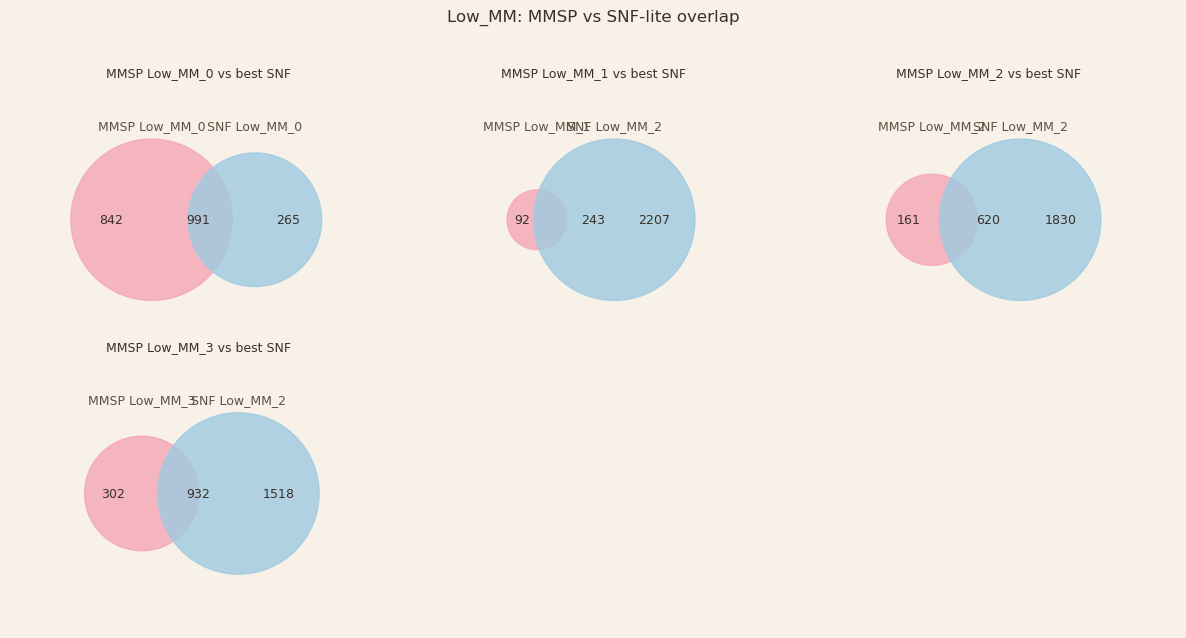


=== Mid_MM: MMSP vs SNF-lite Venn grid ===


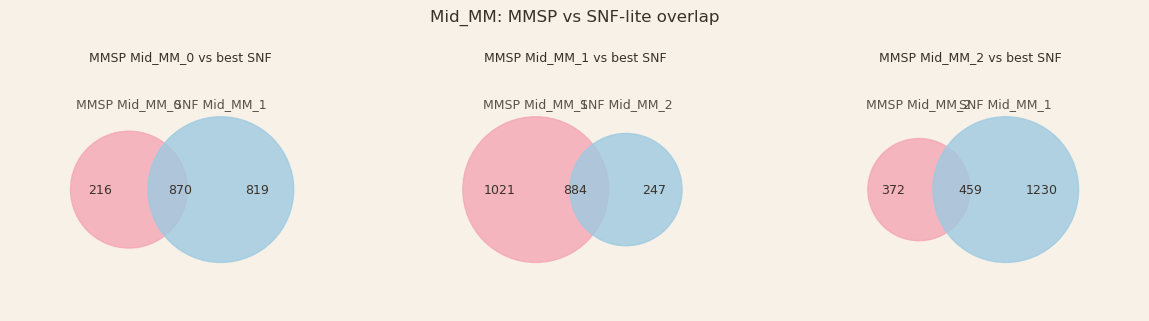


=== High_MM: MMSP vs SNF-lite Venn grid ===


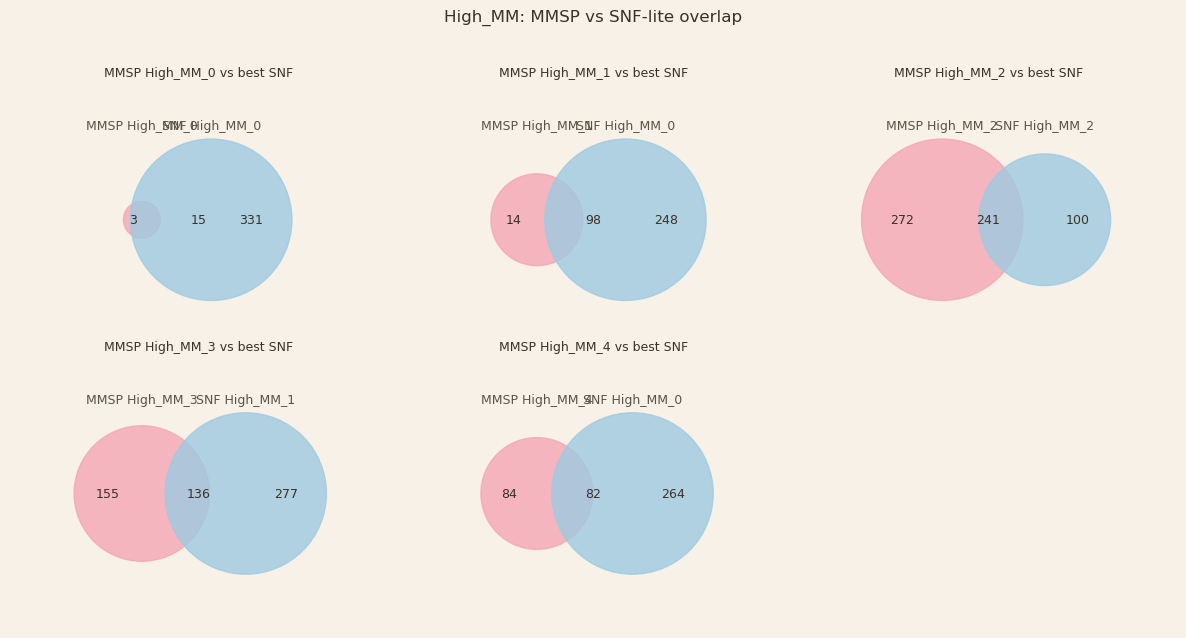

In [45]:
import numpy as np
import matplotlib.pyplot as plt

PORTF_BG = "#f7f1e8"

def plot_mmsp_snf_venn_grid(g: pd.DataFrame, stratum: str):
    """
    For a given stratum subset `g` (with mmsp_col and snf_col),
    draw a grid of MMSP-vs-best-SNF Venn-style panels.
    """
    ctab = pd.crosstab(g[mmsp_col], g[snf_col])
    mmsp_clusters = ctab.index.tolist()

    n_panels = len(mmsp_clusters)
    n_cols = min(3, n_panels)
    n_rows = int(np.ceil(n_panels / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 3.2 * n_rows),
        facecolor=PORTF_BG,
    )
    axes = np.atleast_1d(axes).ravel()

    # Hide all axes to start
    for ax in axes:
        ax.set_visible(False)

    for ax, m in zip(axes, mmsp_clusters):
        ax.set_visible(True)
        ax.set_facecolor(PORTF_BG)

        row = ctab.loc[m]
        best_snf = row.idxmax()

        n_overlap = int(row[best_snf])
        n_m = int(row.sum())
        n_s = int(ctab[best_snf].sum())

        only_m = n_m - n_overlap
        only_s = n_s - n_overlap

        # Radii roughly ∝ sqrt(size) to avoid crazy area differences
        r1 = np.sqrt(n_m)
        r2 = np.sqrt(n_s)
        scale = 0.06 / max(r1, r2)
        r1 *= scale
        r2 *= scale

        # Positions of circle centres
        center1 = (-r2 * 0.7, 0.0)  # MMSP
        center2 = (r1 * 0.7, 0.0)   # SNF

        circle1 = plt.Circle(center1, r1, color="#f4a6b5", alpha=0.8)
        circle2 = plt.Circle(center2, r2, color="#9ecae1", alpha=0.8)
        ax.add_patch(circle1)
        ax.add_patch(circle2)

        ax.set_xlim(-0.14, 0.14)
        ax.set_ylim(-0.10, 0.10)
        ax.set_aspect("equal")
        ax.axis("off")

        # Labels (set names)
        ax.text(
            center1[0],
            0.065,
            f"MMSP {m}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="#5a5245",
        )
        ax.text(
            center2[0],
            0.065,
            f"SNF {best_snf}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="#5a5245",
        )

        # Region counts
        ax.text(
            center1[0] - r1 * 0.5,
            0.0,
            str(only_m),
            ha="center",
            va="center",
            fontsize=9,
            color="#3a3126",
        )
        ax.text(
            center2[0] + r2 * 0.5,
            0.0,
            str(only_s),
            ha="center",
            va="center",
            fontsize=9,
            color="#3a3126",
        )
        ax.text(
            0.0,
            0.0,
            str(n_overlap),
            ha="center",
            va="center",
            fontsize=9,
            color="#3a3126",
        )

        ax.set_title(
            f"MMSP {m} vs best SNF",
            fontsize=9,
            color="#3a3126",
            pad=6,
        )

    fig.suptitle(
        f"{stratum}: MMSP vs SNF-lite overlap",
        fontsize=12,
        color="#3a3126",
        y=0.99,
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

for s in strata_order:
    g = df[df[stratum_col] == s].dropna(subset=[mmsp_col, snf_col])
    if g.empty:
        print(f"[WARN] No data in {s}, skipping.")
        continue
    print(f"\n=== {s}: MMSP vs SNF-lite Venn grid ===")
    plot_mmsp_snf_venn_grid(g, s)


In [47]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path

# ============================================================
# CONFIGURATION
# ============================================================
PORTF_BG = "#F7F1E8"
ROOT = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP")
OUT_FIG = ROOT / "reports" / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

# MMSP Palette (Standard)
PALETTE_MMSP = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
                "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

# SNF Palette (Viridis-ish to match your Heatmaps)
# 0=Purple, 1=Teal, 2=Yellow
PALETTE_SNF = ["#440154", "#21918c", "#fde725"] 

def draw_sankey(ax, matrix, left_labels, right_labels, left_colors, right_colors):
    """
    Draws a high-quality bipartite Sankey diagram with Bezier curves.
    """
    matrix = np.array(matrix)
    n_left, n_right = matrix.shape
    
    # Calculate totals
    left_totals = matrix.sum(axis=1)
    right_totals = matrix.sum(axis=0)
    grand_total = matrix.sum()
    
    # Layout Config
    x_left, x_right = 0.05, 0.95
    bar_width = 0.04
    gap_fraction = 0.15 # 15% of vertical space is gaps
    
    # Vertical Scaling
    # Unit height = (1.0 - total gaps) / total patients
    scale = (1.0 - gap_fraction) / grand_total
    
    # --- 1. Calculate Node Positions (Top to Bottom) ---
    
    # Left Nodes (MMSP)
    left_y = []
    left_heights = []
    current_y = 1.0
    left_gap = gap_fraction / (n_left - 1) if n_left > 1 else 0
    
    for i in range(n_left):
        h = left_totals[i] * scale
        left_heights.append(h)
        left_y.append(current_y - h/2) # Center point
        current_y -= (h + left_gap)
        
    # Right Nodes (SNF)
    right_y = []
    right_heights = []
    current_y = 1.0
    right_gap = gap_fraction / (n_right - 1) if n_right > 1 else 0
    
    for i in range(n_right):
        h = right_totals[i] * scale
        right_heights.append(h)
        right_y.append(current_y - h/2)
        current_y -= (h + right_gap)
        
    # --- 2. Draw Flow Ribbons ---
    # Track "current" vertical position for each node to stack flows neatly
    left_y_cursor = [y + h/2 for y, h in zip(left_y, left_heights)]
    right_y_cursor = [y + h/2 for y, h in zip(right_y, right_heights)]
    
    for i in range(n_left):
        for j in range(n_right):
            count = matrix[i, j]
            if count == 0: continue
            
            h_link = count * scale
            
            # Start/End Y coords (Top of ribbon)
            y1 = left_y_cursor[i]
            y2 = right_y_cursor[j]
            
            # Update cursors
            left_y_cursor[i] -= h_link
            right_y_cursor[j] -= h_link
            
            # Bezier Curve Construction
            verts = [
                (x_left + bar_width, y1),                   # Top-Left
                (x_left + bar_width + 0.3, y1),             # Control 1
                (x_right - bar_width - 0.3, y2),            # Control 2
                (x_right - bar_width, y2),                  # Top-Right
                (x_right - bar_width, y2 - h_link),         # Bottom-Right
                (x_right - bar_width - 0.3, y2 - h_link),   # Control 3
                (x_left + bar_width + 0.3, y1 - h_link),    # Control 4
                (x_left + bar_width, y1 - h_link),          # Bottom-Left
                (x_left + bar_width, y1),                   # Close
            ]
            codes = [
                mpath.Path.MOVETO,
                mpath.Path.CURVE4, mpath.Path.CURVE4, mpath.Path.LINETO,
                mpath.Path.LINETO,
                mpath.Path.CURVE4, mpath.Path.CURVE4, mpath.Path.LINETO,
                mpath.Path.CLOSEPOLY,
            ]
            
            path = mpath.Path(verts, codes)
            color = left_colors[i % len(left_colors)]
            
            # Add Patch (Ribbon)
            patch = mpatches.PathPatch(
                path, facecolor=color, alpha=0.4, edgecolor="none"
            )
            ax.add_patch(patch)

    # --- 3. Draw Nodes & Labels ---
    # Left (MMSP)
    for i in range(n_left):
        ax.bar(x_left, left_heights[i], width=bar_width, 
               bottom=left_y[i]-left_heights[i]/2,
               color=left_colors[i % len(left_colors)], 
               edgecolor="none", align='edge')
        
        # Label: "MMSP 0\n(n=991)"
        ax.text(x_left - 0.02, left_y[i], 
                f"{left_labels[i]}\n(n={left_totals[i]})", 
                ha='right', va='center', fontsize=9, 
                fontweight='bold', color="#555")

    # Right (SNF)
    for i in range(n_right):
        ax.bar(x_right - bar_width, right_heights[i], width=bar_width, 
               bottom=right_y[i]-right_heights[i]/2,
               color=right_colors[i % len(right_colors)], 
               edgecolor="none", align='edge')
        
        ax.text(x_right + 0.02, right_y[i], 
                f"{right_labels[i]}\n(n={right_totals[i]})", 
                ha='left', va='center', fontsize=9, 
                fontweight='bold', color="#555")

    # --- 4. Cleanup ---
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.05)
    ax.axis('off')

# ============================================================
# EXECUTION
# ============================================================

# Data from your cross-tabs
data_map = {
    "Low_MM": {
        "matrix": [
            [991, 187, 655],  # MMSP 0
            [61,  31,  243],  # MMSP 1
            [23,  138, 620],  # MMSP 2
            [181, 121, 932]   # MMSP 3
        ],
        "left_labels": ["MMSP 0", "MMSP 1", "MMSP 2", "MMSP 3"]
    },
    "Mid_MM": {
        "matrix": [
            [103, 870, 113],  # MMSP 0
            [661, 360, 884],  # MMSP 1
            [238, 459, 134]   # MMSP 2
        ],
        "left_labels": ["MMSP 0", "MMSP 1", "MMSP 2"]
    },
    "High_MM": {
        "matrix": [
            [15, 3, 0],       # MMSP 0
            [98, 12, 2],      # MMSP 1
            [63, 209, 241],   # MMSP 2
            [88, 136, 67],    # MMSP 3
            [82, 53, 31]      # MMSP 4
        ],
        "left_labels": ["MMSP 0", "MMSP 1", "MMSP 2", "MMSP 3", "MMSP 4"]
    }
}

snf_labels = ["SNF 0", "SNF 1", "SNF 2"]

for stratum, d in data_map.items():
    print(f"Generating Sankey for {stratum}...")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor(PORTF_BG)
    ax.set_facecolor(PORTF_BG)
    
    draw_sankey(
        ax, 
        d["matrix"], 
        d["left_labels"], 
        snf_labels, 
        PALETTE_MMSP, 
        PALETTE_SNF
    )
    
    plt.tight_layout()
    out_path = OUT_FIG / f"sankey_{stratum}.png"
    plt.savefig(out_path, dpi=300, facecolor=PORTF_BG, bbox_inches='tight')
    plt.close()
    
    print(f"[Saved] {out_path}")

Generating Sankey for Low_MM...
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/sankey_Low_MM.png
Generating Sankey for Mid_MM...
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/sankey_Mid_MM.png
Generating Sankey for High_MM...
[Saved] /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/figures/sankey_High_MM.png
